In [326]:
# Add Dependencies
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics
#from prophet.diagnostics import performance_metrics



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [327]:
# Poiters to the datasets
integ_data_set = 'top_counties.csv'
zhvi_single_family_homes_by_county_url = 'https://files.zillowstatic.com/research/public_csvs/zhvi/County_zhvi_uc_sfr_tier_0.33_0.67_sm_sa_month.csv?t=1720392210'


In [328]:
# Read in the data for the top_counties
integ_top_counties_df = pd.read_csv(
    integ_data_set,
    parse_dates=True,
    infer_datetime_format=True
    )

/var/folders/h3/xtqxxtn9551c8dd44chd8lbc0000gn/T/ipykernel_4593/1627415981.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  integ_top_counties_df = pd.read_csv(


In [329]:
# Read in the ZHVI
zhvi_county_df = pd.read_csv(
    zhvi_single_family_homes_by_county_url,
    parse_dates=True,
    infer_datetime_format=True
    )

/var/folders/h3/xtqxxtn9551c8dd44chd8lbc0000gn/T/ipykernel_4593/234310628.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  zhvi_county_df = pd.read_csv(


In [330]:
print(integ_top_counties_df.head())
print(integ_top_counties_df.tail())

   Unnamed: 0  GeoFips        GeoName      2022      CAGR  Total Growth Rate
0           0     8031     Denver, CO  1.342352  6.732323          18.007194
1           1    30031   Gallatin, MT  1.126722  7.792158          39.259185
2           2    12021    Collier, FL  1.081409  6.919575          23.419708
3           3    41017  Deschutes, OR  1.056533  8.269753          30.814977
4           4    49049       Utah, UT  1.048108  6.837103          35.070734
    Unnamed: 0  GeoFips         GeoName      2022      CAGR  Total Growth Rate
18          18    30063    Missoula, MT  0.827218  6.713997          10.545783
19          19    45019  Charleston, SC  0.820833  7.252412          19.288897
20          20    47037    Davidson, TN  0.813328  7.190962          12.737907
21          21    12035     Flagler, FL  0.811683  6.634026          32.083438
22          22    47187  Williamson, TN  0.810069  7.320579          41.720325


In [331]:
zhvi_county_df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,StateCodeFIPS,MunicipalCodeFIPS,2000-01-31,...,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30
0,3101,0,Los Angeles County,county,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",6,37,223227.570289,...,908470.164191,920227.893039,929015.843494,934548.891149,933373.048335,928068.136342,923865.536315,9.247795e+05,9.284306e+05,9.309001e+05
1,139,1,Cook County,county,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",17,31,155001.856326,...,318401.265838,319825.649452,320807.462970,321484.462541,322011.240173,323401.039876,326043.702340,3.292884e+05,3.316914e+05,3.331743e+05
2,1090,2,Harris County,county,TX,TX,"Houston-The Woodlands-Sugar Land, TX",48,201,113426.768603,...,290095.008822,290139.115275,289887.928358,289601.583693,289719.518949,290207.306644,291249.723603,2.923441e+05,2.929599e+05,2.928385e+05
3,2402,3,Maricopa County,county,AZ,AZ,"Phoenix-Mesa-Chandler, AZ",4,13,147617.388832,...,473709.417278,475960.153050,477802.198730,478802.388963,479165.533584,479740.411788,481323.229115,4.832995e+05,4.848863e+05,4.851605e+05
4,2841,4,San Diego County,county,CA,CA,"San Diego-Chula Vista-Carlsbad, CA",6,73,229910.294473,...,951680.611779,961908.232012,968876.125006,972538.358823,974985.819772,980208.456178,989791.934438,1.001835e+06,1.012124e+06,1.017484e+06


In [332]:
# Splitting 'GeoName' into 'RegionName' and 'State' and getting it ready to merge
integ_top_counties_df[['RegionName', 'State']] = integ_top_counties_df['GeoName'].str.split(',', expand=True)
integ_top_counties_df['RegionName'] = integ_top_counties_df['RegionName'].str.strip()
integ_top_counties_df['State'] = integ_top_counties_df['State'].str.strip()
integ_top_counties_df['RegionName'] = integ_top_counties_df['RegionName'] + ' County'
integ_counties = integ_top_counties_df[['RegionName', 'State']]

# Display 
print(integ_counties.head())

         RegionName State
0     Denver County    CO
1   Gallatin County    MT
2    Collier County    FL
3  Deschutes County    OR
4       Utah County    UT


In [333]:
# merge to find matching rows
matched_df = pd.merge(integ_counties, zhvi_county_df, on=['RegionName', 'State'], how='inner')
print(matched_df.shape)
print(matched_df.columns)
print(matched_df.head())



(23, 303)
Index(['RegionName', 'State', 'RegionID', 'SizeRank', 'RegionType',
       'StateName', 'Metro', 'StateCodeFIPS', 'MunicipalCodeFIPS',
       '2000-01-31',
       ...
       '2023-09-30', '2023-10-31', '2023-11-30', '2023-12-31', '2024-01-31',
       '2024-02-29', '2024-03-31', '2024-04-30', '2024-05-31', '2024-06-30'],
      dtype='object', length=303)
         RegionName State  RegionID  SizeRank RegionType StateName  \
0     Denver County    CO       989        96     county        CO   
1   Gallatin County    MT      2299       544     county        MT   
2    Collier County    FL      1638       191     county        FL   
3  Deschutes County    OR      2679       344     county        OR   
4       Utah County    UT       322       105     county        UT   

                        Metro  StateCodeFIPS  MunicipalCodeFIPS  \
0  Denver-Aurora-Lakewood, CO              8                 31   
1                 Bozeman, MT             30                 31   
2     Naples

In [334]:
# Keep date columns 'YYYY-MM-DD', 'RegionName' and 'State' and drop everything else
columns_to_keep = ['RegionName', 'State'] + [col for col in matched_df.columns if col.endswith('31') or col.endswith('30') or col.endswith('29') or col.endswith('28')]
filtered_df = matched_df[columns_to_keep]
filtered_df['County_State'] = filtered_df['RegionName'] + ', ' + filtered_df['State']
filtered_df.drop(['RegionName', 'State'], axis=1, inplace=True)

# filtered_df.columns
# Move 'County_State' to be the first column
cols = ['County_State'] + [col for col in filtered_df.columns if col != 'County_State']

# Reorder the DataFrame
filtered_df = filtered_df[cols]
# print(filtered_df.columns)
filtered_df.head()

/var/folders/h3/xtqxxtn9551c8dd44chd8lbc0000gn/T/ipykernel_4593/3970805886.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['County_State'] = filtered_df['RegionName'] + ', ' + filtered_df['State']
/var/folders/h3/xtqxxtn9551c8dd44chd8lbc0000gn/T/ipykernel_4593/3970805886.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop(['RegionName', 'State'], axis=1, inplace=True)


,County_State,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,...,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30
0,"Denver County, CO",188363.475014,189466.504205,190602.880953,193367.950670,196210.983682,199246.923223,201952.807309,204624.575749,207277.773170,...,620530.780336,621513.046641,621975.050484,621267.328216,619763.871817,618542.404492,618522.220482,619088.332300,619020.357167,617569.490636
1,"Gallatin County, MT",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,731229.698881,735647.526411,739520.652109,743529.565498,747972.115065,755583.224396,763941.003854,770989.226478,773576.698043,772879.309481
2,"Collier County, FL",190845.457885,191065.876601,192010.824040,193702.464206,195842.883047,197589.083724,199427.162255,201224.100102,203254.421657,...,711559.343580,715724.256888,719785.606207,723502.829825,726651.785804,729131.320977,731364.249989,731868.673262,730262.881223,725597.455523
3,"Deschutes County, OR",153707.717620,154007.399548,154359.502214,155017.199333,155622.253712,156078.028455,156433.451760,156998.215773,157734.867313,...,677827.263624,682512.425123,684813.458042,684649.840690,682218.044658,680635.732868,681042.303921,683505.947191,686223.609764,687962.951948
4,"Utah County, UT",NaN,NaN,NaN,NaN,192970.602342,192757.573730,192596.774045,192583.153208,192988.575854,...,546160.681471,547845.582968,549275.767408,550084.739452,550037.216580,550281.761656,551369.809751,552469.997548,552694.972610,551856.643926


In [335]:
nan_rows = filtered_df[filtered_df.isna().any(axis=1)]
nan_rows


,County_State,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,...,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30
1,"Gallatin County, MT",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,731229.698881,735647.526411,739520.652109,743529.565498,747972.115065,755583.224396,763941.003854,770989.226478,773576.698043,772879.309481
3,"Deschutes County, OR",153707.717620,154007.399548,154359.502214,155017.199333,155622.253712,156078.028455,156433.451760,156998.215773,157734.867313,...,677827.263624,682512.425123,684813.458042,684649.840690,682218.044658,680635.732868,681042.303921,683505.947191,686223.609764,687962.951948
4,"Utah County, UT",NaN,NaN,NaN,NaN,192970.602342,192757.573730,192596.774045,192583.153208,192988.575854,...,546160.681471,547845.582968,549275.767408,550084.739452,550037.216580,550281.761656,551369.809751,552469.997548,552694.972610,551856.643926
10,"Washington County, UT",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,538684.696960,538460.579980,538166.440107,537545.629061,537341.711873,538162.444436,540405.376373,542800.988217,543765.549621,543020.841305
11,"Pinal County, AZ",138097.340842,138428.980610,138669.516693,139115.505697,139313.557588,139525.669388,139754.357401,140034.704273,140524.532823,...,373826.308919,375109.749488,375633.836461,375365.229759,375692.105083,376632.563922,378523.997729,380190.702947,381184.033873,381106.173083
13,"Kootenai County, ID",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,567557.744171,566461.113553,563697.172392,561241.920100,559065.102552,558957.480908,560778.403702,563332.626701,565207.337549,565740.466567
17,"Canyon County, ID",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,398575.466447,400955.476037,402375.424226,403174.205306,402646.065863,403102.911653,404882.940661,406822.912037,408159.006694,408333.217866
18,"Missoula County, MT",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,564268.380706,566441.491906,567206.305900,566814.145945,567959.546841,569851.158331,572213.102385,573928.567686,574483.601138,574663.873045


In [336]:
# Rows where the data is complete
non_nan_rows = filtered_df[filtered_df.notna().all(axis=1)]

# Print the rows without NaN values to inspect them
print(non_nan_rows)

               County_State     2000-01-31     2000-02-29     2000-03-31  \
0         Denver County, CO  188363.475014  189466.504205  190602.880953   
2        Collier County, FL  190845.457885  191065.876601  192010.824040   
5         Martin County, FL  145544.999124  145500.188868  145561.514937   
6         Benton County, AR  109451.094679  109678.205475  109724.592718   
7     Palm Beach County, FL  143681.145053  144086.050120  144530.776927   
8   Indian River County, FL  113548.050471  113833.312450  114167.140338   
9        Boulder County, CO  245011.535904  246048.499731  247326.292115   
12        Travis County, TX  191526.715453  192170.809577  192759.562095   
14          Hall County, GA  140486.251676  140475.281226  140684.689169   
15      Sarasota County, FL  127644.433780  127944.741615  128526.148238   
16     Salt Lake County, UT  182291.711765  182394.211433  182580.654732   
19    Charleston County, SC  150186.091627  150575.884283  151079.963750   
20      Davi

In [337]:
# Filter for start and end dates
start_date = '2010-01-31'
end_date = '2024-06-30'

# List of date columns to keep based on the date range
date_columns_to_keep = [col for col in filtered_df.columns if (col >= start_date and col <= end_date) or col == 'County_State']

# Create the new DataFrame with only the required columns
date_filtered_df = filtered_df[date_columns_to_keep]

date_filtered_df.head()


,County_State,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,...,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30
0,"Denver County, CO",247806.052034,250318.247692,252306.108833,252444.971495,250375.857962,247874.739773,245598.977256,244310.146734,243326.358741,...,620530.780336,621513.046641,621975.050484,621267.328216,619763.871817,618542.404492,618522.220482,619088.332300,619020.357167,617569.490636
1,"Gallatin County, MT",273099.671447,271802.191296,271154.749128,270638.538557,270574.350946,270105.982216,269366.476439,268622.852710,268254.071756,...,731229.698881,735647.526411,739520.652109,743529.565498,747972.115065,755583.224396,763941.003854,770989.226478,773576.698043,772879.309481
2,"Collier County, FL",284394.304505,282989.452149,282488.766542,283108.167068,283837.905859,284168.658802,283143.000031,281345.890712,279185.127086,...,711559.343580,715724.256888,719785.606207,723502.829825,726651.785804,729131.320977,731364.249989,731868.673262,730262.881223,725597.455523
3,"Deschutes County, OR",232811.717747,231516.353383,231895.859297,231829.182087,230100.147828,225988.767565,221163.708293,218122.601909,217048.101997,...,677827.263624,682512.425123,684813.458042,684649.840690,682218.044658,680635.732868,681042.303921,683505.947191,686223.609764,687962.951948
4,"Utah County, UT",223638.536508,222100.360660,220802.750971,220380.941916,219695.926309,218475.173020,216524.056917,214470.816463,212771.954545,...,546160.681471,547845.582968,549275.767408,550084.739452,550037.216580,550281.761656,551369.809751,552469.997548,552694.972610,551856.643926


In [338]:
# Rows where the data is complete
county_data_df = date_filtered_df[date_filtered_df.notna().all(axis=1)]

# Print the rows without NaN values to inspect them
print(county_data_df)

               County_State     2010-01-31     2010-02-28     2010-03-31  \
0         Denver County, CO  247806.052034  250318.247692  252306.108833   
1       Gallatin County, MT  273099.671447  271802.191296  271154.749128   
2        Collier County, FL  284394.304505  282989.452149  282488.766542   
3      Deschutes County, OR  232811.717747  231516.353383  231895.859297   
4           Utah County, UT  223638.536508  222100.360660  220802.750971   
5         Martin County, FL  214803.375566  215421.914532  215452.178212   
6         Benton County, AR  146224.655989  145941.381704  145449.076719   
7     Palm Beach County, FL  211074.654203  210287.306640  210272.780586   
8   Indian River County, FL  152317.699275  152773.661828  153311.874716   
9        Boulder County, CO  338381.802981  339461.373978  340099.599012   
10    Washington County, UT  184939.843423  184689.206724  184172.997972   
11         Pinal County, AZ  125851.681791  126921.887645  128194.645679   
12        Tr

In [339]:
# Add Compounded Annual Growth Rate (CAGR)
# CAGR % = ((end value / start value) ** 1/years -1) * 100


# Get start and end years to calculate number of years 
start_year = int(start_date.split('-')[0])
end_year = int(end_date.split('-')[0])
number_of_years = end_year - start_year


# Function to calculate CAGR as a %
def calculate_cagr(end_value, start_value):
    '''
    This function calcualtes CAGR as a percentage

    Inputs:
    star_year: int (eg: '2010')
    end_value: int (eg: '2024')
    number_of_years: int (eg: '14')

    Output: float (eg: '9.175390')
    '''
    return ((end_value / start_value)**(1 / number_of_years) - 1) * 100


# Apply the function using lambda 
county_data_df['CAGR'] = county_data_df.apply(
    # pass in the row and send the start and end date data to the calculation function
    lambda row: calculate_cagr(row[end_date], row[start_date]), axis=1
)

# Move CAGR next to 'County_State' for my readability and sort them
cols = ['County_State', 'CAGR'] + [col for col in county_data_df.columns if col not in ['County_State', 'CAGR']]
county_data_df = county_data_df[cols]
county_data_df = county_data_df.sort_values(by='CAGR', ascending=False)
county_data_df = county_data_df.reset_index(drop=True)

print(county_data_df.head())

            County_State      CAGR     2010-01-31     2010-02-28  \
0      Canyon County, ID  9.175390  119472.568096  117705.404297   
1       Pinal County, AZ  8.235692  125851.681791  126921.887645   
2   Deschutes County, OR  8.046684  232811.717747  231516.353383   
3  Washington County, UT  7.997397  184939.843423  184689.206724   
4    Kootenai County, ID  7.934348  194259.304070  192928.174797   

      2010-03-31     2010-04-30     2010-05-31     2010-06-30     2010-07-31  \
0  116583.775268  116533.494953  116815.460359  115645.405461  113562.499772   
1  128194.645679  128132.463249  126175.867048  123490.208782  121857.745034   
2  231895.859297  231829.182087  230100.147828  225988.767565  221163.708293   
3  184172.997972  183183.794504  181681.361919  179884.568278  178278.292545   
4  191060.256518  190340.284779  190187.409066  190018.936091  187819.097272   

      2010-08-31  ...     2023-09-30     2023-10-31     2023-11-30  \
0  111388.027767  ...  398575.466447  40

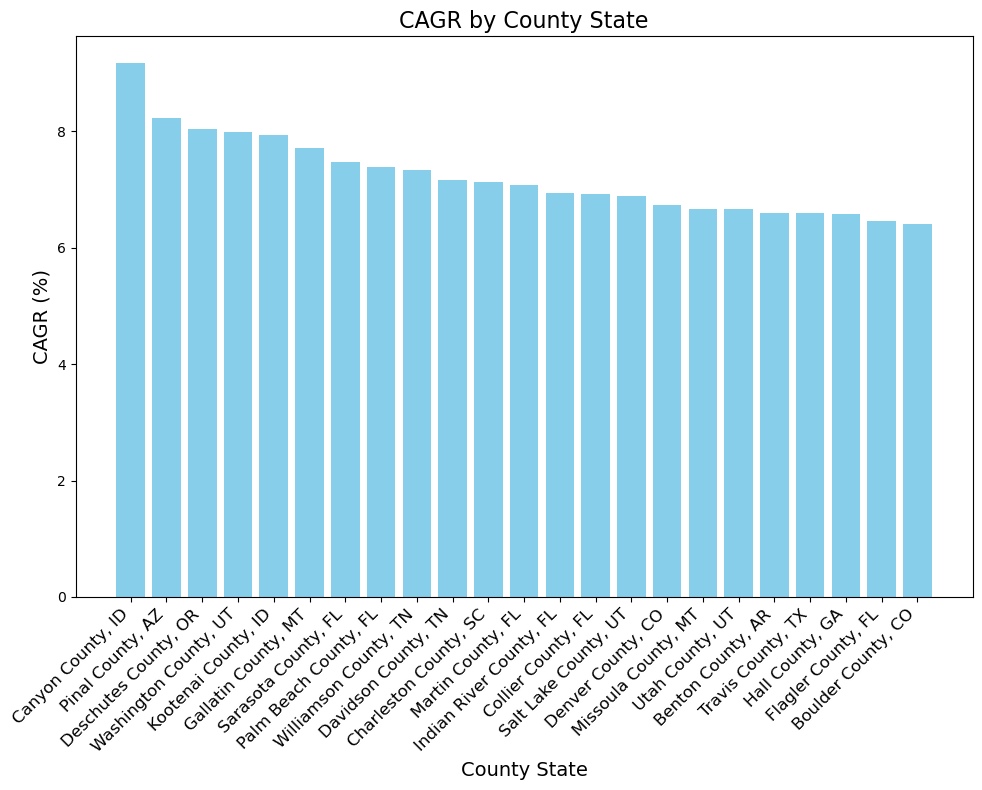

In [340]:
# Set the size of the plot
plt.figure(figsize=(10, 8))

# Create the bar chart
plt.bar(county_data_df['County_State'], county_data_df['CAGR'], color='skyblue')

# Add title, labels with font sizes
plt.title('CAGR by County State', fontsize=16)
plt.xlabel('County State', fontsize=14)
plt.ylabel('CAGR (%)', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

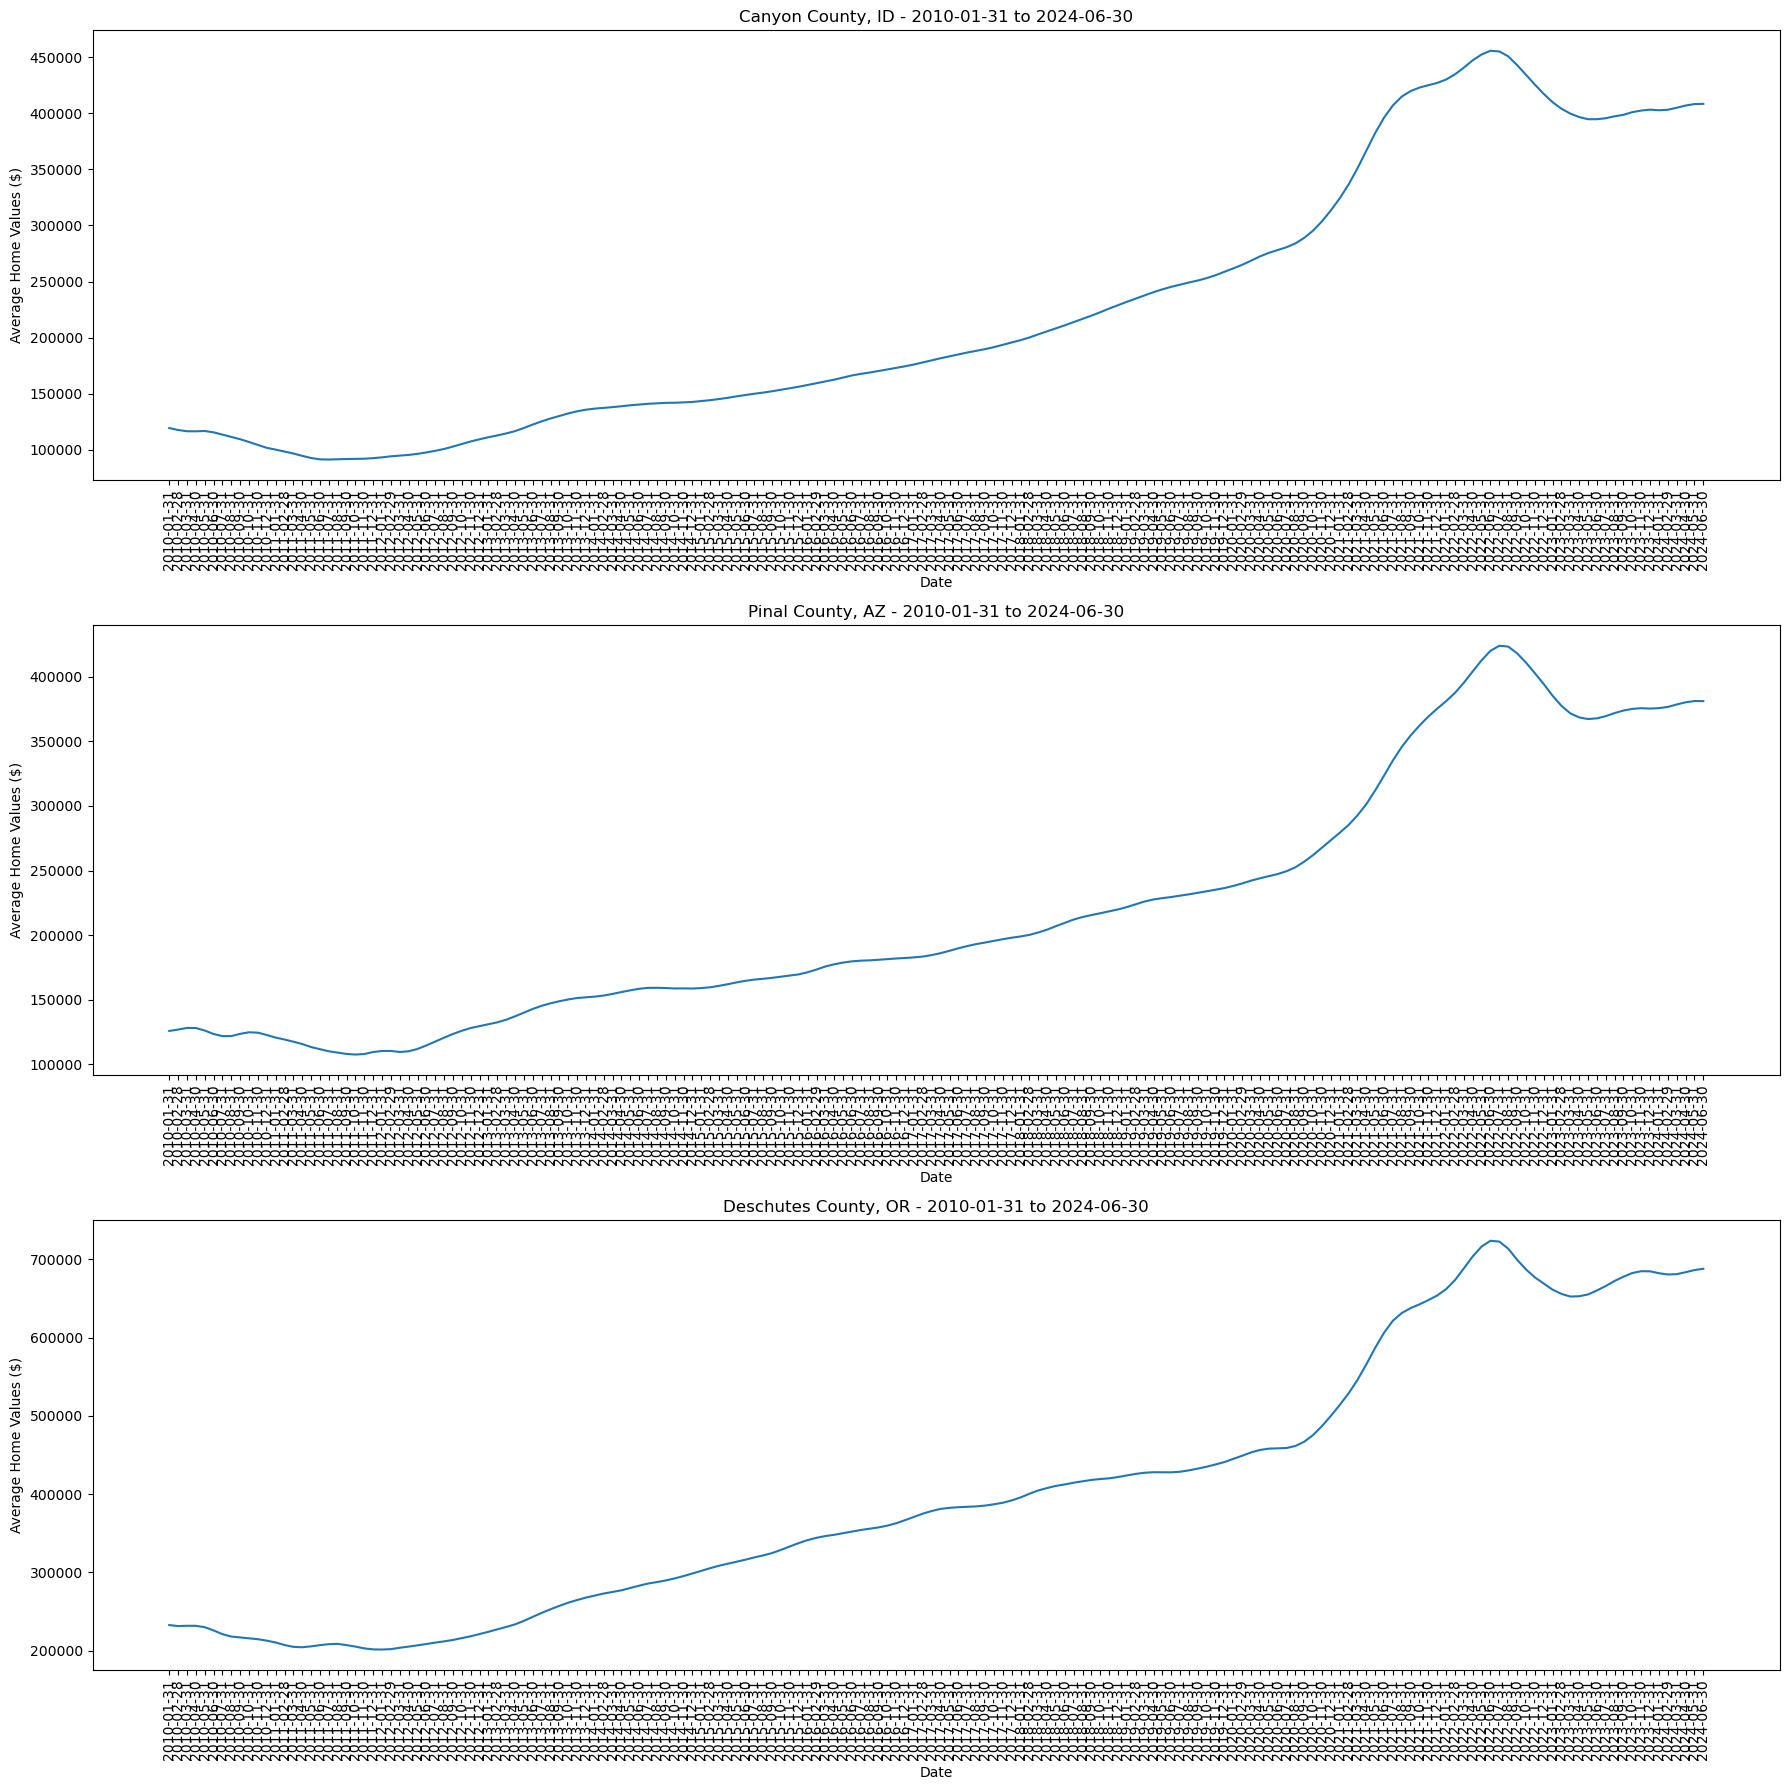

In [341]:
# Select the first three rows for plotting
data_to_plot = county_data_df.head(3)

# Convert columns to datetime for plotting
date_columns = data_to_plot.columns.drop(['County_State', 'CAGR'])

# Create a figure with subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(18, 18))

# Iterate over the selected rows
for idx, (index, row) in enumerate(data_to_plot.iterrows()):
    # Plot each row's data in a subplot
    axes[idx].plot(date_columns, row[date_columns].values, linestyle='-')
    # Set title
    axes[idx].set_title(f"{row['County_State']} - {start_date} to {end_date}")
    # Set x and y labels
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Average Home Values ($)')
    # Rotate x-axis labels
    axes[idx].tick_params(axis='x', rotation=90)

# Display
plt.tight_layout()
plt.show()

In [342]:
# Prepare for Predictions
canyon_county_id_df = county_data_df.iloc[[0]]
pinal_county_az_df = county_data_df.iloc[[1]]
deschutes_county_or_df = county_data_df.iloc[[2]]

In [343]:
# Drop the 'County_State' and 'CAGR' columns
canyon_county_id_df = canyon_county_id_df.drop(columns=['County_State', 'CAGR'])

# Melting the DataFrame to make 'ds' as date columns and 'y' as values
prophet_canyon_county_df = canyon_county_id_df.melt(var_name='ds', value_name='y')

# Converting 'ds' to datetime format
prophet_canyon_county_df['ds'] = pd.to_datetime(prophet_canyon_county_df['ds'])

# Display the new DataFrame ready for Prophet
print(prophet_canyon_county_df.head())

          ds              y
0 2010-01-31  119472.568096
1 2010-02-28  117705.404297
2 2010-03-31  116583.775268
3 2010-04-30  116533.494953
4 2010-05-31  116815.460359


In [344]:
# Calling the Prophet constructor and fitting the df
model_canyon_county = Prophet().fit(prophet_canyon_county_df)

14:29:16 - cmdstanpy - INFO - Chain [1] start processing
14:29:16 - cmdstanpy - INFO - Chain [1] done processing


In [345]:
# Make future df
future_canyon_county = model_canyon_county.make_future_dataframe(periods=12, freq='M')

# Make Prediction
forcast_canyon_county = model_canyon_county.predict(future_canyon_county)

forcast_canyon_county.tail(15)

/Users/davidkaplan/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
171,2024-04-30,435663.217948,410864.427147,466256.168888,435663.217948,435663.217948,3914.046969,3914.046969,3914.046969,3914.046969,3914.046969,3914.046969,0.0,0.0,0.0,439577.264918
172,2024-05-31,437948.027586,414241.830596,471834.888560,437948.027586,437948.027586,5470.534858,5470.534858,5470.534858,5470.534858,5470.534858,5470.534858,0.0,0.0,0.0,443418.562444
173,2024-06-30,440159.133687,416848.265552,472650.654913,440159.133687,440159.133687,4367.019589,4367.019589,4367.019589,4367.019589,4367.019589,4367.019589,0.0,0.0,0.0,444526.153276
174,2024-07-31,442443.943324,426004.071165,480779.757751,442443.943324,442443.943324,10068.976643,10068.976643,10068.976643,10068.976643,10068.976643,10068.976643,0.0,0.0,0.0,452512.919968
175,2024-08-31,444728.752962,424597.451232,477292.131901,444671.046240,444776.644943,5890.145913,5890.145913,5890.145913,5890.145913,5890.145913,5890.145913,0.0,0.0,0.0,450618.898875
176,2024-09-30,446939.859062,422917.722623,476488.499660,446745.933605,447138.210309,2505.552358,2505.552358,2505.552358,2505.552358,2505.552358,2505.552358,0.0,0.0,0.0,449445.411420
177,2024-10-31,449224.668700,422332.360309,475588.365983,448812.911785,449635.731574,485.438332,485.438332,485.438332,485.438332,485.438332,485.438332,0.0,0.0,0.0,449710.107032
178,2024-11-30,451435.774801,425644.033844,478144.574543,450848.567706,452138.283173,1102.034771,1102.034771,1102.034771,1102.034771,1102.034771,1102.034771,0.0,0.0,0.0,452537.809572
179,2024-12-31,453720.584438,432876.161224,486352.785060,452915.984552,454723.371541,4705.926443,4705.926443,4705.926443,4705.926443,4705.926443,4705.926443,0.0,0.0,0.0,458426.510881
180,2025-01-31,456005.394076,442134.615173,499318.277113,454956.931404,457454.081188,13745.708995,13745.708995,13745.708995,13745.708995,13745.708995,13745.708995,0.0,0.0,0.0,469751.103071


/Users/davidkaplan/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/davidkaplan/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


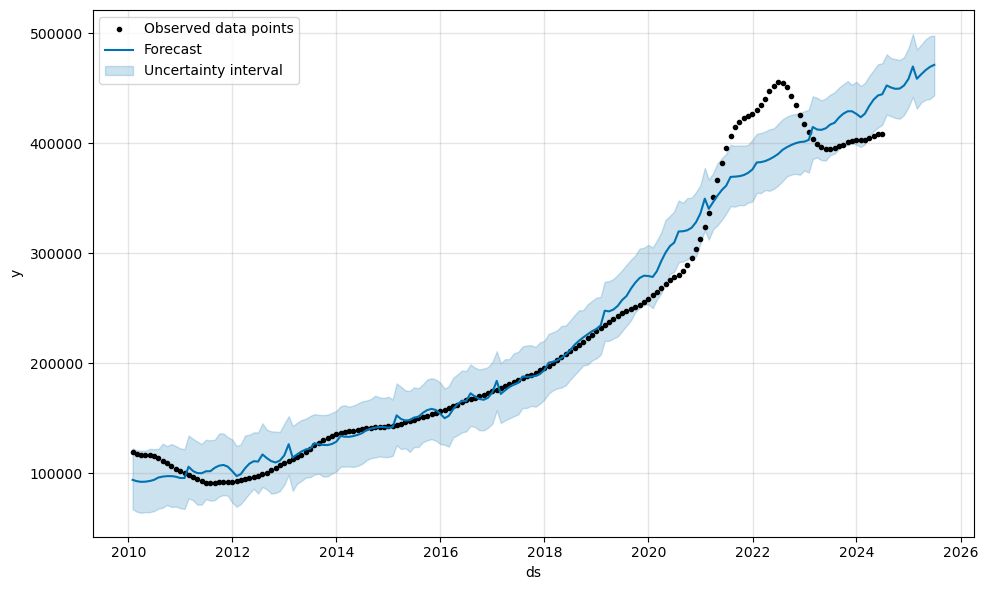

In [346]:
# Plot the Forcast
fig_forcast_canyon_county = model_canyon_county.plot(forcast_canyon_county, include_legend=True)

/Users/davidkaplan/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/davidkaplan/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Users/davidkaplan/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python date

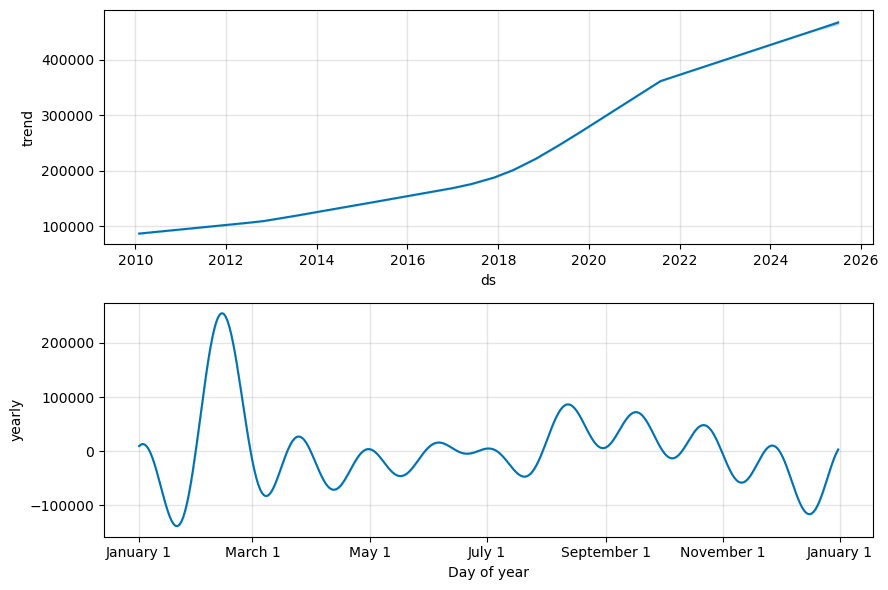

In [347]:
# Plot the Components
fig_components_of_forcast_canyon_county = model_canyon_county.plot_components(forcast_canyon_county)

/Users/davidkaplan/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/davidkaplan/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


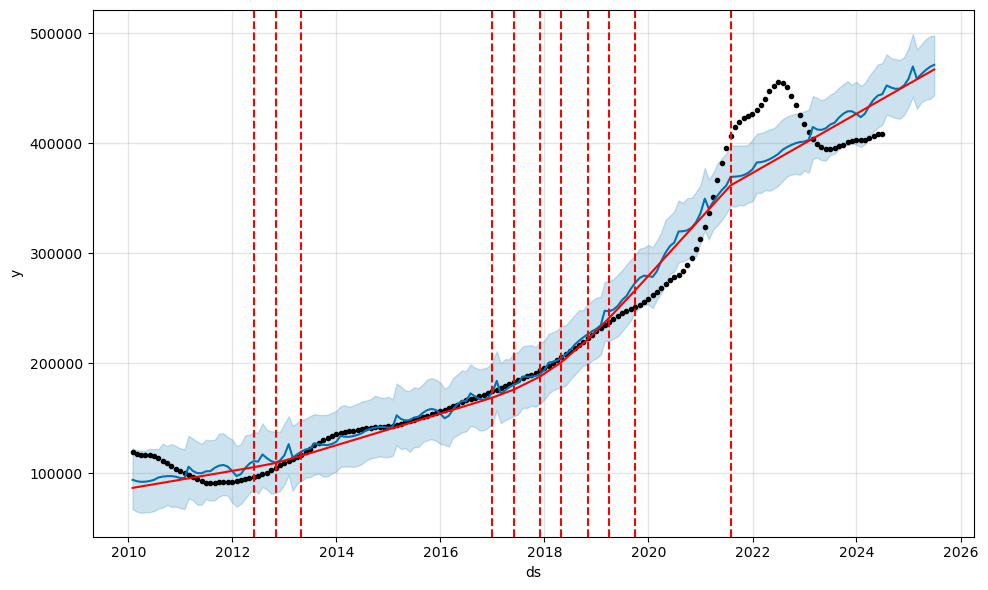

In [348]:
# Plot the Chagepoints
fig_changepoints_forcast_canyon_county = model_canyon_county.plot(forcast_canyon_county)
a = add_changepoints_to_plot(fig_changepoints_forcast_canyon_county.gca(), model_canyon_county, forcast_canyon_county)
plt.show()


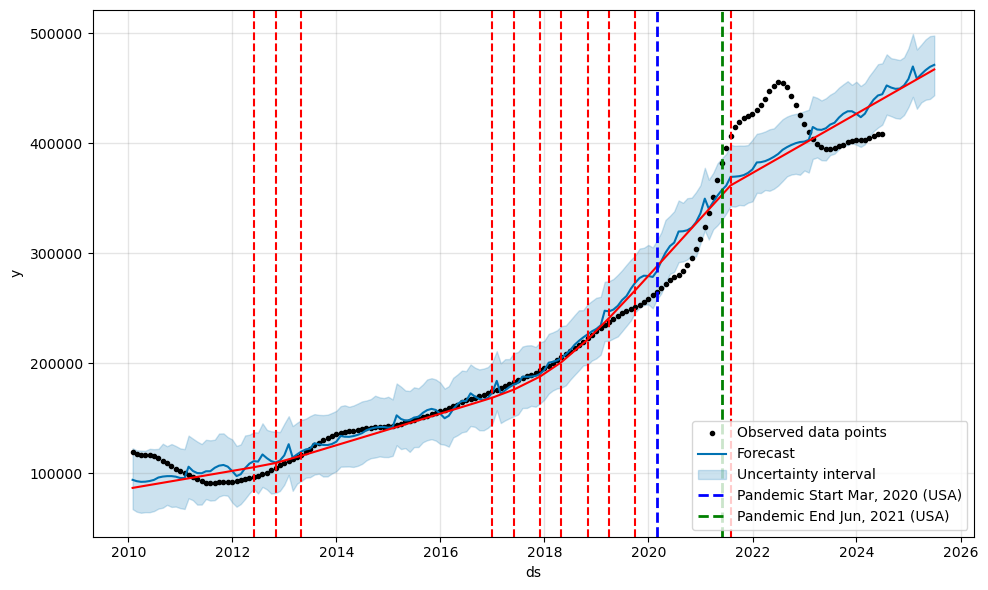

In [349]:
# Plot the Chagepoints plus Covid
fig_changepoints_forcast_canyon_county = model_canyon_county.plot(forcast_canyon_county)
a = add_changepoints_to_plot(fig_changepoints_forcast_canyon_county.gca(), model_canyon_county, forcast_canyon_county)

# Adding lines for COVID-19 pandemic start and end dates
plt.axvline(pd.to_datetime('2020-03-01'), color='blue', linestyle='--', lw=2, label='Pandemic Start Mar, 2020 (USA)')
plt.axvline(pd.to_datetime('2021-06-01'), color='green', linestyle='--', lw=2, label='Pandemic End Jun, 2021 (USA)')

# Adding a legend to the plot to explain the lines
plt.legend()

# Show the plot with changepoints and pandemic timelines highlighted
plt.show()

In [350]:
# Parameters for cross-validation
initial = '72 Months'  # 6 years of data as the initial training set
period = '6 Months'    # every 6 months a new forecast is made
horizon = '12 Months'  # predicting 12 months ahead

#df_cv = cross_validation(model_canyon_county, initial=initial, period=period, horizon=horizon)
df_cv = cross_validation(model_canyon_county, initial='2190 days', period='180 days', horizon = '365 days')
df_cv

  0%|          | 0/16 [00:00<?, ?it/s]

14:29:17 - cmdstanpy - INFO - Chain [1] start processing
14:29:18 - cmdstanpy - INFO - Chain [1] done processing
14:29:18 - cmdstanpy - INFO - Chain [1] start processing
14:29:18 - cmdstanpy - INFO - Chain [1] done processing
14:29:18 - cmdstanpy - INFO - Chain [1] start processing
14:29:19 - cmdstanpy - INFO - Chain [1] done processing
14:29:19 - cmdstanpy - INFO - Chain [1] start processing
14:29:20 - cmdstanpy - INFO - Chain [1] done processing
14:29:20 - cmdstanpy - INFO - Chain [1] start processing
14:29:20 - cmdstanpy - INFO - Chain [1] done processing
14:29:20 - cmdstanpy - INFO - Chain [1] start processing
14:29:20 - cmdstanpy - INFO - Chain [1] done processing
14:29:20 - cmdstanpy - INFO - Chain [1] start processing
14:29:21 - cmdstanpy - INFO - Chain [1] done processing
14:29:21 - cmdstanpy - INFO - Chain [1] start processing
14:29:21 - cmdstanpy - INFO - Chain [1] done processing
14:29:21 - cmdstanpy - INFO - Chain [1] start processing
14:29:21 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-02-29,157360.583632,156910.206260,157803.475287,159418.765904,2016-02-08
1,2016-03-31,157930.435413,157322.756639,158556.375794,160966.127222,2016-02-08
2,2016-04-30,158783.395381,157793.321421,159781.916249,162579.327354,2016-02-08
3,2016-05-31,160073.816703,158499.288721,161570.202716,164488.293330,2016-02-08
4,2016-06-30,161547.105726,159350.163698,163610.995991,166326.298755,2016-02-08
...,...,...,...,...,...,...
187,2024-02-29,492899.224371,469101.059138,519400.268559,403102.911653,2023-07-01
188,2024-03-31,500148.080397,474089.110788,524619.030727,404882.940661,2023-07-01
189,2024-04-30,507613.040915,482682.695385,532244.487285,406822.912037,2023-07-01
190,2024-05-31,514591.673938,491101.532485,540379.427093,408159.006694,2023-07-01


In [354]:
# performance_metrics
df_p = performance_metrics(df_cv)
print(df_p.head())

  horizon           mse          rmse           mae      mape     mdape  \
0 36 days  8.600287e+08  29326.245207  15660.102865  0.042870  0.018666   
1 40 days  8.599027e+08  29324.098278  15611.457208  0.042579  0.018666   
2 42 days  8.590821e+08  29310.103005  15432.348217  0.041713  0.012911   
3 46 days  8.576358e+08  29285.418903  15236.659715  0.040793  0.012862   
4 47 days  9.161422e+08  30267.841755  16976.548090  0.045948  0.012911   

      smape  coverage  
0  0.041935  0.105263  
1  0.041641  0.157895  
2  0.040766  0.210526  
3  0.039832  0.210526  
4  0.045258  0.157895  


/Users/davidkaplan/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/Users/davidkaplan/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


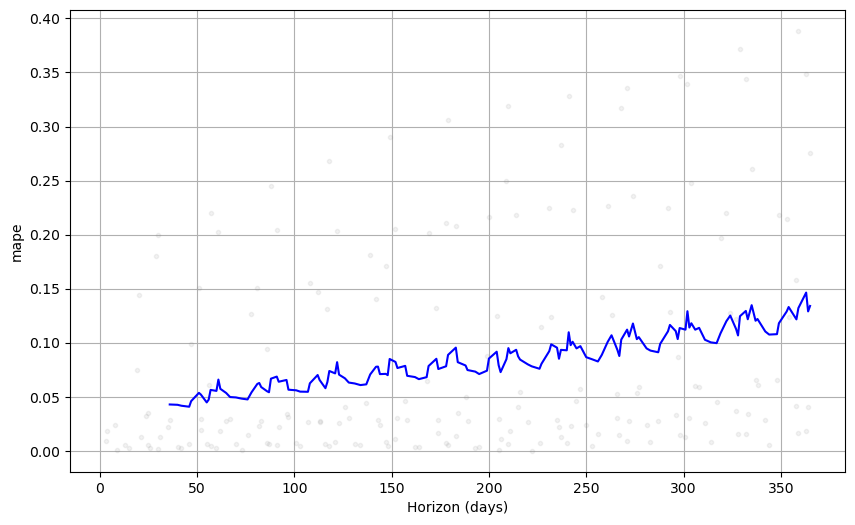

In [352]:
fig = plot_cross_validation_metric(df_cv, metric='mape')